In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import shutil
import warnings
warnings.filterwarnings("ignore")
import tensorflow 
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import noisereduce as nr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

2023-06-07 12:19:25.132066: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-07 12:19:25.655696: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
class Classifier(nn.Module):
    def __init__(self, num_class):
        super(Classifier, self).__init__()
        self.num_class = num_class
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=8, kernel_size=13, padding="valid", stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=3)
        self.drop1 = nn.Dropout(p=0.4)
        
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=11, padding="valid", stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=3)
        self.drop2 = nn.Dropout(p=0.4)
        
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=9, padding="valid", stride=1)
        self.pool3 = nn.MaxPool1d(kernel_size=3)
        self.drop3 = nn.Dropout(p=0.4)
        
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, padding="valid", stride=1)
        self.pool4 = nn.MaxPool1d(kernel_size=3)
        self.drop4 = nn.Dropout(p=0.3)
        
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(in_features=6080, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.drop5 = nn.Dropout(p=0.4)
        self.out = nn.Linear(in_features=128, out_features=self.num_class)
        
    def forward(self, x):
        intermediate_results = []
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)
        intermediate_results.append(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)
        intermediate_results.append(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.drop3(x)
        intermediate_results.append(x)
        
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool4(x)
        x = self.drop4(x)
        intermediate_results.append(x)
        
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.drop5(x)
        scores = self.out(x)
        return scores, intermediate_results

In [4]:
train_audio_path = '../../google_speech_commands/'
labels = []
for folder in os.listdir(train_audio_path):
    if os.path.isdir(os.path.join(train_audio_path, folder)) and not folder.startswith("."):
        labels.append(folder)
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

sr=8000   # sample rate
# vad = malaya_speech.vad.webrtc()
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

print("shape of waves array",np.array(all_wave).shape)
print("shape of labels array",np.array(all_label).shape)

yes
no
up
down
left
right
on
off
stop
go
shape of waves array (21312, 8000)
shape of labels array (21312,)


In [13]:
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

# y = np_utils.to_categorical(y, num_classes=len(labels))
# y = np.eye(len(classes))[y]

all_wave = np.array(all_wave).reshape(-1, 1, 8000)

x_tr, x_val, y_tr, y_val = train_test_split(
    np.array(all_wave),np.array(y),
    stratify=y,test_size = 0.3,random_state=122,shuffle=True)

In [14]:
class Dataset:
    def __init__(self, X, y):
        assert X.shape[0] == y.shape[0], 'Got different numbers of data and labels'
        self.X, self.y = X, y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x, y = self.X[idx], self.y[idx]
        return x, y

In [15]:
dataset = Dataset(
    X=x_tr,
    y=y_tr
)
train_loader = DataLoader(
    dataset=dataset,
    batch_size=128,
    shuffle=True
)
dataset = Dataset(
    X=x_val,
    y=y_val
)
val_loader = DataLoader(
    dataset=dataset,
    batch_size=128,
    shuffle=True
)

In [16]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)
    if i>4:
        break

torch.Size([128, 1, 8000]) torch.Size([128])
torch.Size([128, 1, 8000]) torch.Size([128])
torch.Size([128, 1, 8000]) torch.Size([128])
torch.Size([128, 1, 8000]) torch.Size([128])
torch.Size([128, 1, 8000]) torch.Size([128])
torch.Size([128, 1, 8000]) torch.Size([128])


In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [18]:
model = Classifier(num_class=10).to(device)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 100

In [22]:
best_val_epoch, best_val_loss = 0, 1e6
break_flag = 0
for epoch in range(epochs):  # loop over the dataset multiple times
    model.train()
    t_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        audios, labels = data
        audios, labels = audios.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(audios)
        loss = criterion(outputs, labels)
        t_loss += loss.item()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    t_loss = t_loss / (i+1)
    t_loss = round(t_loss, 5)
    t_acc = round(100*(correct / total), 5)
    model.eval()
    v_loss = 0
    correct = 0
    total = 0
    for i, data in enumerate(val_loader):
        audios, labels = data
        audios, labels = audios.to(device), labels.to(device)
        outputs, _ = model(audios)
        loss = criterion(outputs, labels)
        v_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    v_loss = v_loss/(i+1)
    v_loss = round(v_loss, 5)
    v_acc = round(100*(correct / total), 5)
    if v_loss <= best_val_loss:
        torch.save(model.state_dict(), "kws_baseline_s.h5")
        best_val_epoch = epoch + 1
        best_val_loss = v_loss
        break_flag = 0
    else:
        break_flag += 1
    print(f'Epoch[{epoch+1}]: t_loss: {t_loss} t_acc: {t_acc} v_loss: {v_loss} v_acc: {v_acc}')
    if break_flag >9 :
        break
print('Finished Training')
print('Best model saved at epoch: ', best_val_epoch)

Epoch[1]: t_loss: 2.30172 t_acc: 10.42365 v_loss: 2.29555 v_acc: 13.70034
Epoch[2]: t_loss: 2.22767 t_acc: 16.05443 v_loss: 2.13204 v_acc: 20.55052
Epoch[3]: t_loss: 1.94337 t_acc: 27.95281 v_loss: 1.89804 v_acc: 30.95089
Epoch[4]: t_loss: 1.61585 t_acc: 38.65129 v_loss: 1.55865 v_acc: 41.00719
Epoch[5]: t_loss: 1.39934 t_acc: 46.48746 v_loss: 1.46428 v_acc: 43.10291
Epoch[6]: t_loss: 1.3122 t_acc: 49.72516 v_loss: 1.36482 v_acc: 47.51329
Epoch[7]: t_loss: 1.22881 t_acc: 52.92935 v_loss: 1.29512 v_acc: 50.09384
Epoch[8]: t_loss: 1.15714 t_acc: 55.79836 v_loss: 1.26583 v_acc: 51.07914
Epoch[9]: t_loss: 1.0996 t_acc: 58.19145 v_loss: 1.1657 v_acc: 56.41226
Epoch[10]: t_loss: 1.02486 t_acc: 60.65827 v_loss: 1.08926 v_acc: 59.32124
Epoch[11]: t_loss: 0.96519 t_acc: 63.58761 v_loss: 0.97529 v_acc: 65.76478
Epoch[12]: t_loss: 0.8995 t_acc: 65.7863 v_loss: 0.90392 v_acc: 68.04817
Epoch[13]: t_loss: 0.85312 t_acc: 68.6151 v_loss: 0.91116 v_acc: 68.73632
Epoch[14]: t_loss: 0.79394 t_acc: 71.303

In [23]:
model.load_state_dict(torch.load("kws_baseline_s.h5", map_location='cpu'))
correct = 0
total = 0
pred, actual = [], []
with torch.no_grad():
    for i, data in enumerate(val_loader):
        audios, labels = data
        audios, labels = audios.to(device), labels.to(device)
        outputs, _ = model(audios)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pred = pred + list(predicted.detach().cpu().numpy())
        actual = actual + list(labels.detach().cpu().numpy())
print(f'Test accuracy: {100 * correct /total}')  

Test accuracy: 81.2167657178605


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       646
           1       0.78      0.71      0.74       630
           2       0.82      0.72      0.77       650
           3       0.74      0.83      0.78       629
           4       0.84      0.81      0.82       643
           5       0.84      0.84      0.84       631
           6       0.81      0.89      0.85       647
           7       0.91      0.82      0.86       652
           8       0.85      0.79      0.82       619
           9       0.77      0.90      0.83       647

    accuracy                           0.81      6394
   macro avg       0.81      0.81      0.81      6394
weighted avg       0.81      0.81      0.81      6394



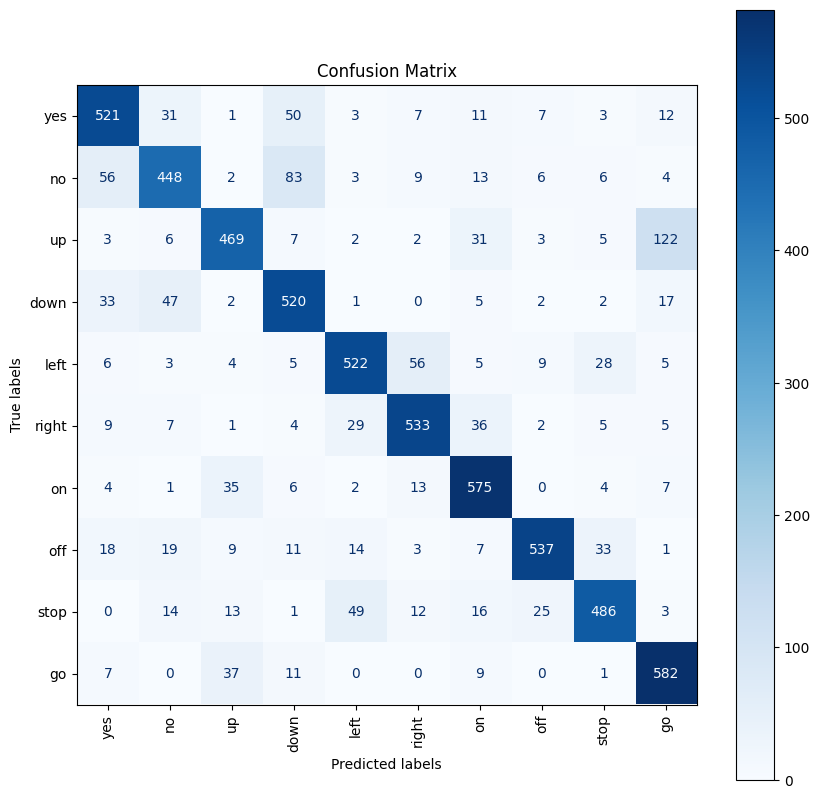

In [24]:
labels = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]
print('Classification Report')
print(classification_report(actual, pred))
cm = confusion_matrix(actual, pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(10,10))
display.plot(ax=ax, cmap=plt.cm.Blues, values_format='g')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels, rotation = 90)
ax.yaxis.set_ticklabels(labels)
plt.show()